### Neste exemplo de aplicação iremos construir um classificador (árvore de decisão) para diferenciar passageiros sobreviventes do não-sobreviventes no naufrágio do Titanic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### No exemplo abaixo, código foi obtido do repositório do github

Caso optar por baixar o arquivo e salvá-lo no mesmo diretório em que semana_1_v2.ipynb, deixe apenas titanic_train.csv como argumento no código abaixo. Exemplo:

bd = pd.read_csv("titanic_train.csv")

In [2]:
bd = pd.read_csv("titanic.csv")

# Colunas da tabela

In [3]:
bd.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# 10 primeiras linhas

In [4]:
bd.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Informação dos atributos

In [5]:
bd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Exemplos de pré-processamento

Verificar a quantidade de valores nulos para cada atributo.
Após fazer a operação abaixo, você verá que os atributos "Age", "Cabin", "Embarked" possuem valores nulos.

In [6]:
np.sum(bd.isna())

/home/jefferson/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

De 891 linhas, vimos que o atributo "Cabin" possui 687 campos. Como esse atributo possui a maioria dos seus campos vazios e provavelmente não faria diferença a sua análise, então removemos ela

In [7]:
bd.drop(labels=['Cabin'], axis = 1, inplace = True)

Ver todos os valores únicos para o atributo "Embarked"

In [8]:
bd['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

Para lidarmos com os valores nulos no atributo "Embarked", podemos utilizar o valor da moda

In [9]:
moda = bd['Embarked'].mode()[0]
bd['Embarked'].fillna(moda, inplace = True)

Ao executar a linha abaixo, verás que ainda tem um atributo com valores nulos

In [10]:
np.sum(bd.isna())

/home/jefferson/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
dtype: int64

Para o atributo 'Age', podemos remover as linhas nulas. Como apenas 'Age' contém valores nulos, então podemos fazer a remoção de apenas linhas em que 'Age' possua valor nulo

In [11]:
bd = bd.dropna()

Também podemos discretizar o atributo Sex

In [12]:
bd['Sex'].replace({'male': 0, 'female': 1}, inplace = True)

Alguns algoritmos de regressão ou de classificação não suportam atributos do tipo string (simbólico). Em outras palavras, devemos também preprocessar o atributo 'Embarked', no qual, cada elemento contém um dos seguintes valores: 'S', 'C' e 'Q'.

A seguir é apresentada a transformação do atributo 'Embarked' em três outros do tipo binário.

In [13]:
bd = pd.get_dummies(bd, columns = ['Embarked'])
bd.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

Outra possibilidade seria a remoção dos atributos 'SibSp', 'Parch', 'Ticket',  'PassengerId' e 'Name', pois esses atributos podem ser desconsiderados para a extração de padrões.

In [14]:
bd.drop(labels=['SibSp', 'Parch', 'Ticket', 'PassengerId', 'Name'], axis = 1, inplace = True)

#### Agora podemos obter algumas informações interessantes
Conforme pode ser visto no mapa de aquecimento abaixo, temos algumas correlações interessantes entre os atributos. Por exemplo, a maior correlação é entre os atributos "Sexo" e "Sobreviveu". Uma explicação para isso é que durante o resgate foram priorizadas mulheres e crianças.

<AxesSubplot:>

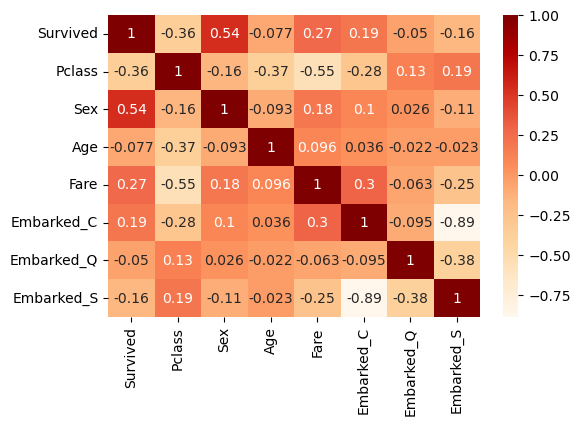

In [15]:
plt.figure(dpi=100)
sns.heatmap(bd.corr(), annot=True, cmap='OrRd')

O próximo passo é a transformação de dados para a próxima aplicação, que será regressão linear.

In [16]:
y = bd['Survived']
X = bd.drop('Survived', axis = 1)

Dividir o conjunto de dados em 90% para treino e o restante, para teste.

In [17]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.10, random_state=123)

# Exemplo de modelo de classificação

Construção de um modelo de classificação

In [18]:
modelo = DecisionTreeClassifier()

Treinamento do modelo

In [19]:
modelo.fit(X_treino, y_treino)

DecisionTreeClassifier()

Plotagem da árvore resultante do treinamento

[Text(0.4798532694327731, 0.9761904761904762, 'x[1] <= 0.5\ngini = 0.483\nsamples = 642\nvalue = [381, 261]'),
 Text(0.15508469012605042, 0.9285714285714286, 'x[2] <= 6.5\ngini = 0.326\nsamples = 410\nvalue = [326, 84]'),
 Text(0.01680672268907563, 0.8809523809523809, 'x[0] <= 2.5\ngini = 0.434\nsamples = 22\nvalue = [7, 15]'),
 Text(0.008403361344537815, 0.8333333333333334, 'gini = 0.0\nsamples = 9\nvalue = [0, 9]'),
 Text(0.025210084033613446, 0.8333333333333334, 'x[3] <= 20.825\ngini = 0.497\nsamples = 13\nvalue = [7, 6]'),
 Text(0.01680672268907563, 0.7857142857142857, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.03361344537815126, 0.7857142857142857, 'x[3] <= 31.331\ngini = 0.219\nsamples = 8\nvalue = [7, 1]'),
 Text(0.025210084033613446, 0.7380952380952381, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.04201680672268908, 0.7380952380952381, 'x[3] <= 35.538\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.03361344537815126, 0.6904761904761905, 'gini = 0.0\nsample

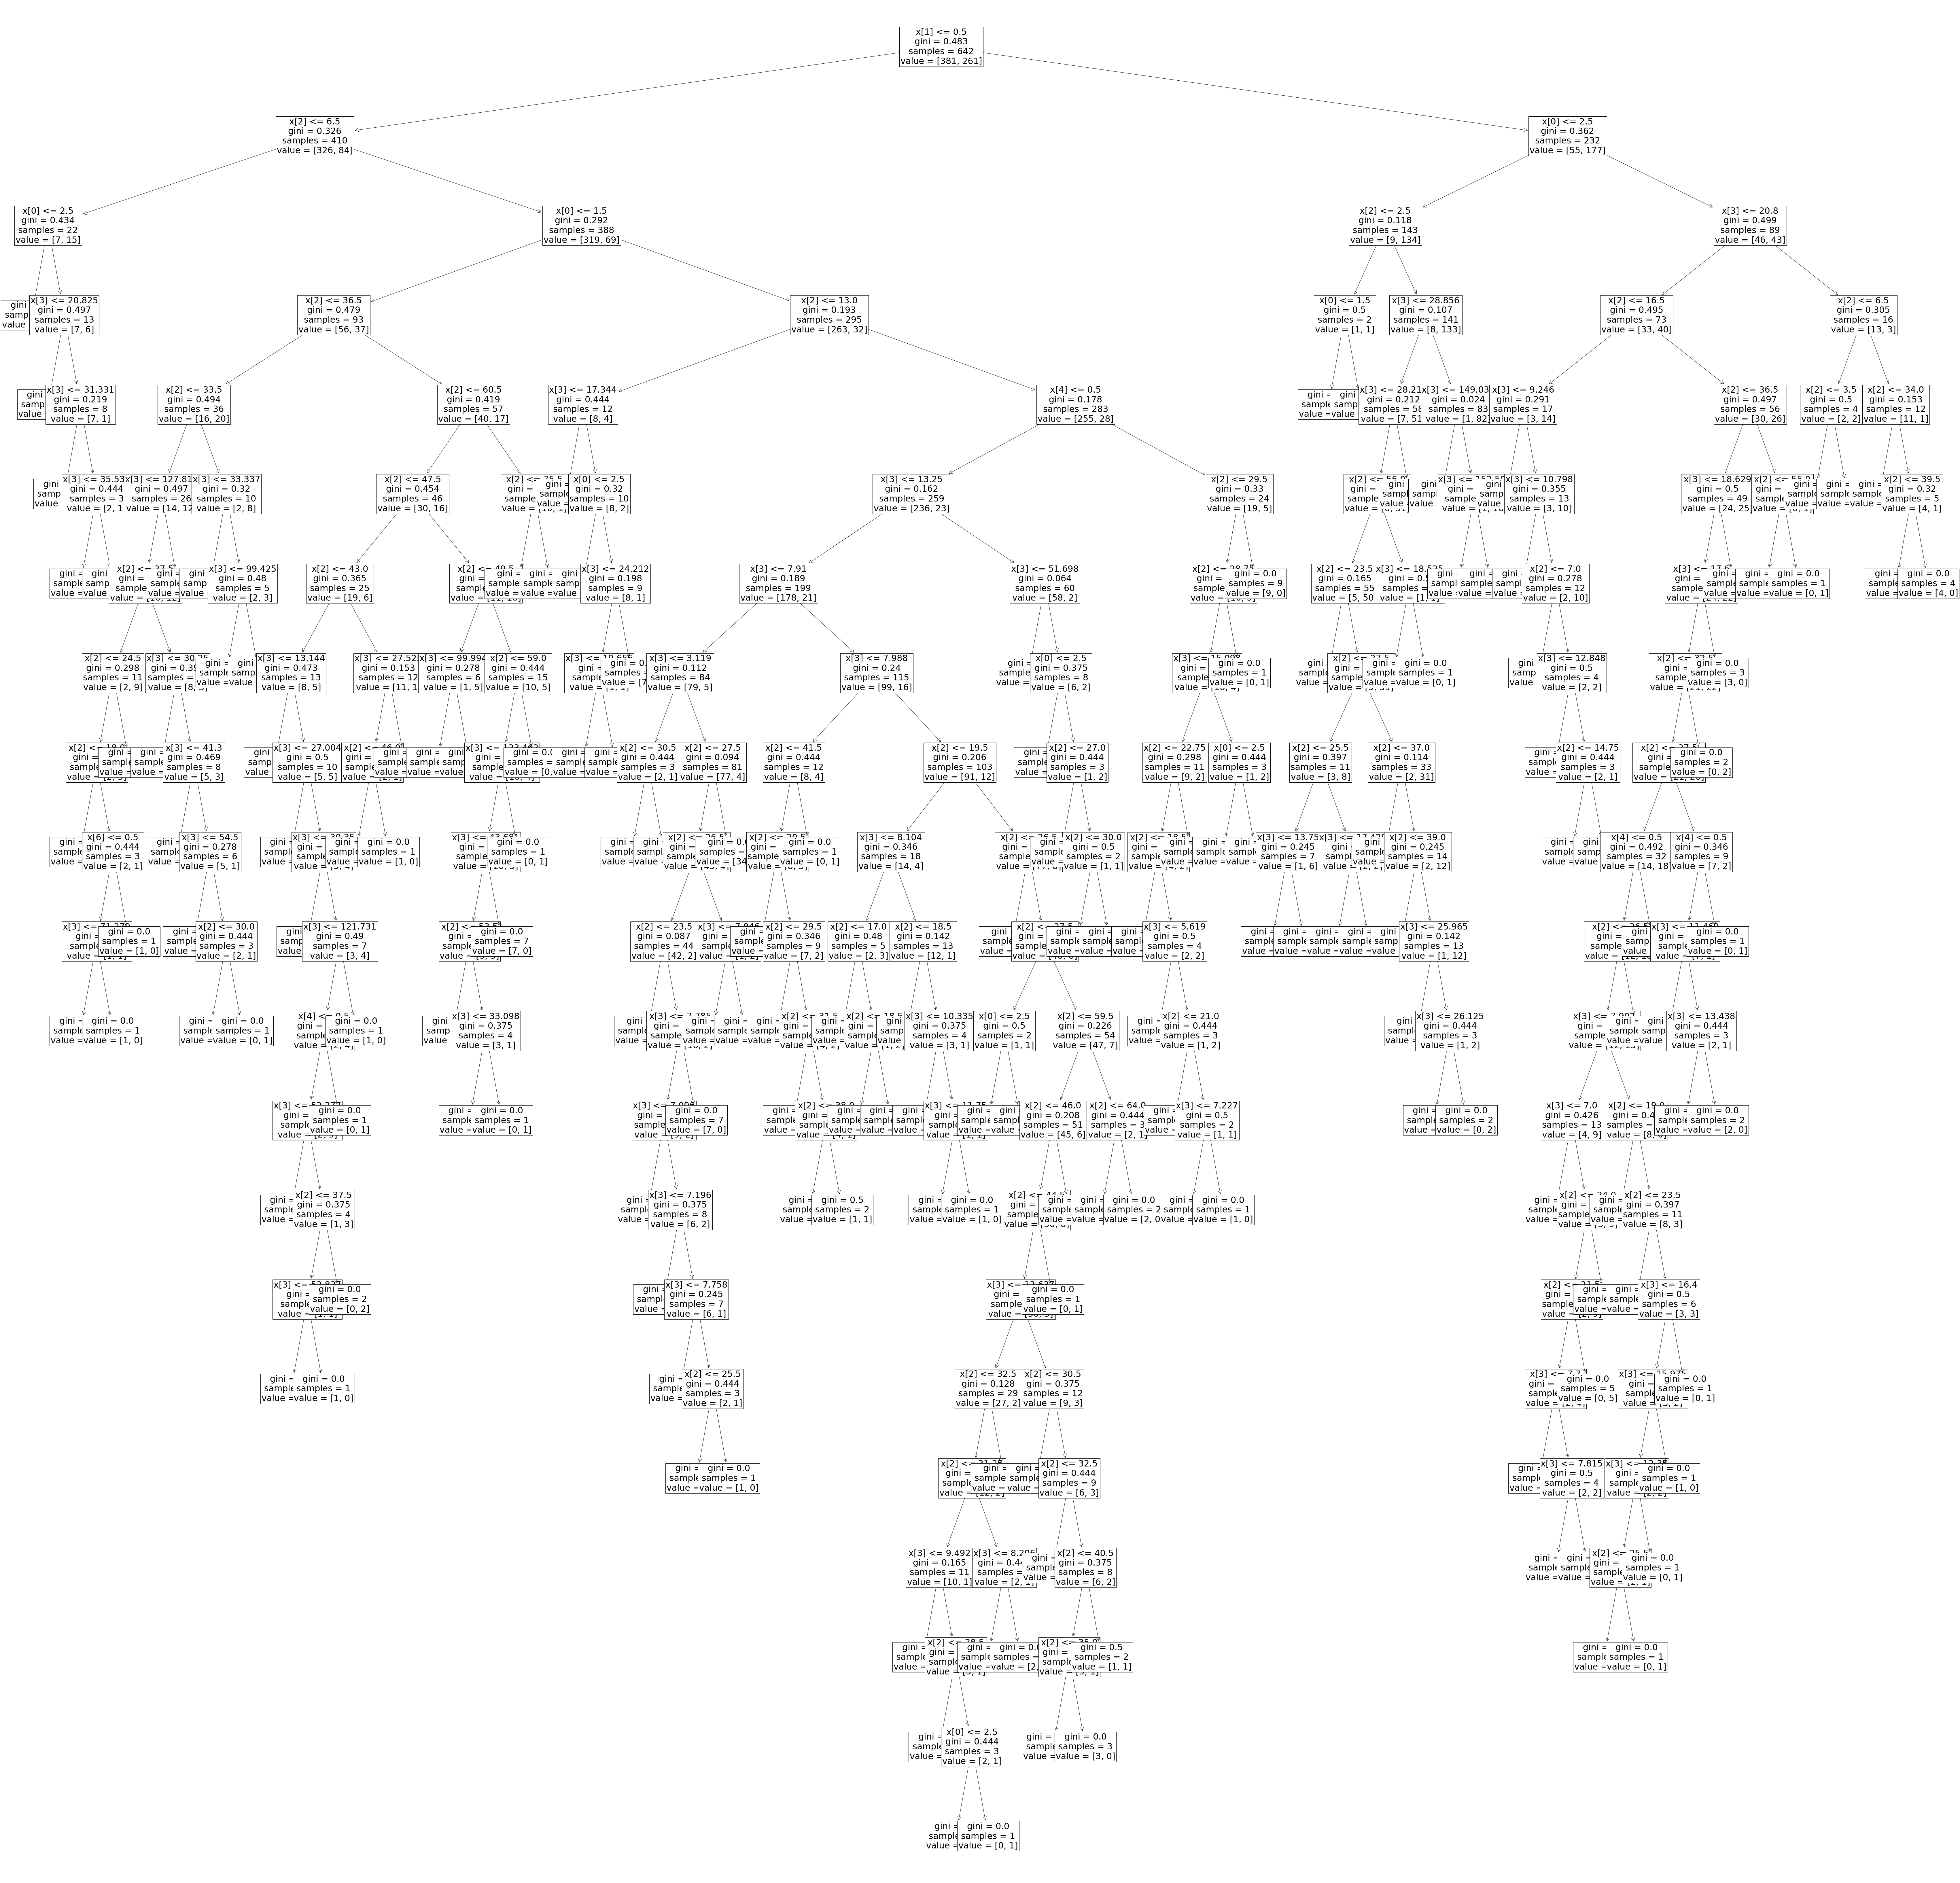

In [20]:
plt.figure(figsize=[120,120])
plot_tree(modelo, fontsize=30)

# Predição e avaliação do modelo

Resultados predicação do conjunto de teste

In [21]:
res = modelo.predict(X_teste)

#### Acurácia

In [22]:
accuracy_score(y_teste, res)

0.7222222222222222

#### Matriz de confusão

No exemplo abaixo, dos 29 exemplos positivos (sobreviventes), 19 foram classificados corretamente. Dos 43 exemplos negativos (não sobreviventes), apenas 35 foram classificados corretamente.

In [23]:
mat = confusion_matrix(y_teste, res)
mat

array([[34,  9],
       [11, 18]])

Precisão (valor preditivo positivo): probabilidade de verdadeiros positivos (VP) serem classificados como verdadeiros positivos

Verdadeiros positivos (VP): sobreviventes classificados corretamente como sobreviventes

Verdadeiros negativos (VN): não sobreviventes classificados corretamente como não sobreviventes

Falsos negativos (FN): sobreviventes classificados como não sobreviventes

Falsos positivos (FN): não sobreviventes classificados como sobreviventes

precisão = VP / (VP + FP)

acurácia = (VP + VN) / (VP + FP + VN + FN)

In [24]:
precision_score(y_teste, res)

0.6666666666666666

In [25]:
mat[1][1] / (mat[1][1] + mat[0][1])

0.6666666666666666

Revocação (sensitividade ou sensibilidade): taxa de VP classificados corretamente

Revocação = VP / (VP + FN)

In [26]:
recall_score(y_teste, res)

0.6206896551724138

In [27]:
mat[1][1] / (mat[1][1] + mat[1][0])

0.6206896551724138

Valor preditivo negativo (VPN): probabilidade de verdadeiros negativos (VN) serem classificados como verdadeiros negativos

VPN = VN / (VN + FN)

In [28]:
mat[0][0] / (mat[0][0] + mat[1][0])

0.7555555555555555

Especificidade: taxa de VN classificados corretamente

VPN = VN / (VN + FP)

In [29]:
mat[0][0] / (mat[0][0] + mat[0][1])

0.7906976744186046